# Project 2
## Lending Club Classification
Our goal for the Lending Club classification exercise is to create a model that determines whether or not a loanee will default.  

A loan enters default status once it is overdue by 120 days.  For the purpose of our classification exercise we will assume loans in a late status will convert into a default status.   As such, late statuses will be considered in our model as defaulted loans.

We will begin by looking at a simple Logistic Regression on features that have been created (feature engineered) during our EDA of the data. 

We will then move to performing a Logistic Regression on all features before fine tuning feature selection & hyperparamters for the Logistic Regression model. 

Finally, we will have a look at Random Forests to see if they can out perform a Logistic Regression in this case.  

In [334]:
# Import all our varaibles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set(style='whitegrid', color_codes=True)

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

# scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




To begin, we will import our pre-processed data.  We've identified several category columns and will ensure these are set with the appropriate datatype before moving forward. 

In [272]:
#define category columns
cat_cols = ['grade', 
            'sub_grade',
            'home_ownership',
            'verification_status',
            'loan_status',
            'purpose',
            'addr_state',
            'initial_list_status',
            'application_type',
            'hardship_flag'
           ]

# import data
df_raw = pd.read_csv('../data/processed/LCData_processed.csv', index_col=0)

# convert category columns
for c in cat_cols:
    df_raw[c] = pd.Categorical(df_raw[c])

As mentioned above, we want to build a model based on completed loans - meaning loans that have been fully repaid or defaulted.  Any loan that is currently on-going will be removed from our dataset. 

In [273]:
completed_loan_status = ['Fully Paid', 
                         'Charged Off', 
                         'Default',
                         'Late (16-30 days)',
                         'Late (31-120 days)'
                        ]

# filter our loan data
df = df_raw[df_raw.loan_status.str.contains('|'.join(completed_loan_status))]

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


## Logistic Regression - Feature Engineered Columns
As a starting point, we will build a model using only our engineered columns.  Our engineered columns are as follows:

In [274]:
feat_eng_cols = ['low_deliquent_job',
                 'credit_line_length_mnths',
                 'inq_last_6mths_cat',
                 'pub_rec_cat',
                 'fully_funded',
                 'issue_d_month', 
                 'issue_d_year'
                 ]

With our columns defined, we can create a simple logistic regression to see how well our data performs.

In [275]:
# create our X and y datasets
X = df[feat_eng_cols]
y = df.is_bad

# create the dummies for our category columns
X = pd.get_dummies(X)

# split our data.  Here we use the stratify option to ensure our split datasets contain the same distribution between
# majority & minority class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# scale the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# predict using the training dataset
y_pred = clf.predict(X_train_scaled)

# find the prediction precentage for the 'default' class (which is the second column)
y_score = clf.predict_proba(X_train_scaled)[:,1]

# find the scores
r2_score = clf.score(X_train_scaled, y_train)
mse = mean_squared_error(y_train,y_pred)
roc_auc = roc_auc_score(y_train, y_score)

# print scores
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))

R2: 0.8074194962474714
RSE: 0.43883995232035167
ROC AUC: 0.5659423551308429


The accuracy score states that we are ~81%.  One would assume this is great.  Looking at the ROC AUC score, we find out that the accuracy score is not good at all. 

A roc auc score of ~57% is slightly better than randomly guessing the outcome.  I believe we see this bad score due to unbalanced classes.  Let's take a look at the confusion matrix and classification report.

In [276]:
print(confusion_matrix(y_train, y_pred))

[[152876      0]
 [ 36463      0]]


In [277]:
print(classification_report(y_train, y_pred, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.81      1.00      0.89    152876
          1       0.00      0.00      0.00     36463

avg / total       0.65      0.81      0.72    189339



//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results look even worse now.  We predict 'non-default' for everything.  At the moment, our model is not able to predict when a loanee will default.  It could be due to class imbalance.  

Let's try balancing our classes and re-running the model.

### SMOTE  Class Balancing
Using SMOTE, we are able to bring balance to our minority class, which will hopefully improve our accuracy score. 

In [278]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = pd.get_dummies(df[feat_eng_cols])
y = df.is_bad

# balance our class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

# display the sampled classes
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 203835, 1: 203835})


We now have balanced classes and are ready to perform a logisitc regression to see how well our model predicts the outcome.

In [279]:
# split our data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

# scale the data
sc = StandardScaler()
X_train_scaled_bal = sc.fit_transform(X_train_bal)
X_test_scaled_bal = sc.transform(X_test_bal)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train_scaled_bal, y_train_bal)

# predict using the training dataset
y_pred_fe = clf.predict(X_train_scaled_bal)

# find the prediction precentage for the 'default' class (which is the second column)
y_score_fe = clf.predict_proba(X_train_scaled_bal)[:,1]

# find the scores
r2_score_bal = clf.score(X_train_scaled_bal, y_train_bal)
mse_bal = mean_squared_error(y_train_bal, y_pred_fe)
roc_auc_bal = roc_auc_score(y_train_bal, y_score_fe)

# print scores
print('R2: {}'.format(r2_score_bal))
print('RSE: {}'.format(np.sqrt(mse_bal)))
print('ROC AUC: {}'.format(roc_auc_bal))


R2: 0.5504559250634501
RSE: 0.6704804806529046
ROC AUC: 0.5619283740232979


The ROC AUC score appears to be the same as we saw in our initial tests, however we can see that the accuracy score mirrors our ROC AUC score.  This should mean that we are successfully predicting loan defaults now.  Let's look at our confusion matrix and classification report to confirm. 

In [280]:
confusion_matrix(y_train_bal, y_pred_bal)

array([[ 64397,  88376],
       [ 49073, 103906]])

In [281]:
print(classification_report(y_train_bal, y_pred_bal, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.57      0.42      0.48    152773
          1       0.54      0.68      0.60    152979

avg / total       0.55      0.55      0.54    305752



Although the balanced class allows us to predict the default class, we still have a model that predicts just slight better than randomly guessing the outcome.  

This is most likley due to the few number of features used in the current model.  We can improve the model by adding additional features.

## Predicting based on the majority class
We've seen that our current model performs poorly.  If we were to create a model that always predicts the majority class, how well would our model perform? 

We already know that the majority class is 'non-default' (represented by the 0 class).  Let's calcluate the prediction accuracy of the majority class. 

In [282]:
# find the counts for majority and minority classes
majority = len(df[df.is_bad == 0])
minority = len(df[df.is_bad == 1])

# calculate the accuracy
print('Majority benchmark: {}'.format(majority / (majority + minority)))

Majority benchmark: 0.8074176183289563


If we were to always predict the majority class of 'non-default', we would be accurate about 81% of the time.  

Our current model is only accurate ~51% of the time.  Our goal should be to create a model that can predict better than 81% accuracy. 

## Predicting based on loan grade
We now know that we can achieve about 81% accuracy by simply predicting 'non-default' for every loan.  This doesn't provide a truly accurate model - but it provides us a benchmark.  

We can produce another benchmark by looking at predicting loan default by loan grades.  We will take a look at default rates per loan grades below: 

In [283]:
# Lets calculate the default rates for loans based on lending club's grades
for g in sorted(df.grade.unique()):
    
    #calculate default rate
    default_rate = df[(df.is_bad ==1) & (df.grade==g)].loan_amnt.count() / df[df.grade==g].loan_amnt.count() 

    print('{0}: {1:.3f}'.format(g, default_rate))

A: 0.062
B: 0.128
C: 0.210
D: 0.289
E: 0.360
F: 0.411
G: 0.438


As one would expect, loans of grade 'A' have less likelihood of defaulting when compared to loans of grade 'G'.  Using this approach, we assume that if a loan has a grade of 'A', it will default only 6% of the time.  Our current model will only predict the correct response about 50% of the time, no matter what the loan grade is set to.  We can use the loan grade predictions here for our future tests once we settle on a final model. 

## Logistic Regression - All Columns
We've investigated creating a model using only our engineered columns - which behaves poorly.  Our next step is to create a model using all features (columns).  

We have several features that relate directly to the status of a loan. These features need to be removed from our dataset prior to building our model.

Features will be removed from the dataset if they...
* are related to a lending club defined status (e.g. grade, sub_grade, loan_status)
* are related to the health status of a loan (e.g. current payments, interest collected, late fees etc) 

The features to be removed are as follows:

In [284]:
drop_cols = ['total_pymnt',
             'total_pymnt_inv',
             'total_rec_int',
             'total_rec_late_fee',
             'total_rec_prncp',
             'funded_amnt',
             'funded_amnt_inv',
             'out_prncp',
             'out_prncp_inv',
             'last_pymnt_amnt',
             'loan_status',
             'grade',
            'sub_grade']

In [285]:
# create a new dataset
df_sub = df.drop(drop_cols, axis=1)

# create our X & Y
X = pd.get_dummies(df_sub.drop('is_bad', axis=1))
y = df_sub.is_bad

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Now that we have a dataset, let's try performing a logisitic regression using all features.  Our prior model suffered from class imbalance due to the fact that we had so few features.  We will try the logistic regression without balancing the classes to see how we perform. 

In [286]:
# Build a pipeline
pipe_lr_af = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ])

# fit the data
pipe_lr_af.fit(X_train, y_train)

# predict X
y_pred_lr_af = pipe_lr_af.predict(X_train)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_lr_af = pipe_lr_af.predict_proba(X_train)[:,1]

# find the scores
r2_score = pipe_lr_af.score(X_train, y_train)
mse = mean_squared_error(y_train,y_pred_lr_af)
roc_auc = roc_auc_score(y_train, y_score_lr_af)

# print scores
print('Training Scores')
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))

Training Scores
R2: 0.9054341683435531
RSE: 0.3075155795345122
ROC AUC: 0.8759851049290165


In [287]:
#Let's have a look at the classification report
print(classification_report(y_train, y_pred_lr_af, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.90      1.00      0.94    152880
          1       0.99      0.52      0.68     36459

avg / total       0.91      0.91      0.89    189339



Our scores look considerably better when using all features.  We are properly predicting the default class, which we saw was a problem when using few features for our model. 

Let's validate our scores against our test dataset to verify that we can accurately predict defaults.

In [288]:
# predict X
y_pred_test = pipe_lr_af.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_test = pipe_lr_af.predict_proba(X_test)[:,1]

# find the scores
r2_score = pipe_lr_af.score(X_test, y_test)
mse = mean_squared_error(y_test,y_pred_test)
roc_auc = roc_auc_score(y_test, y_score_test)

# print scores
print('Testing Scores')
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))

Testing Scores
R2: 0.9052508159837754
RSE: 0.30781355398394106
ROC AUC: 0.8737729370665167


When looking at the test results, we find that the model ROC AUC score is algined with what we saw with our training dataset.  Let's validate this using cross validation:

In [289]:
# let's find the cross validation score
scores = cross_val_score(pipe_lr_af, X, y, cv=5)
scores

array([ 0.91547008,  0.93024499,  0.91620289,  0.88496732,  0.86434938])

In [290]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.04807)


Perfect. We've improved our accuracy considerably.  We have a great ROC AUC score of 87% and a cross validation score of 90%.  We can say that having more features allows us to predict outcomes more accurately.    

## Logistic Regression - Feature Selection
With a solid score using Logistic Regression, our next question is whether or not we can reduce the complexity of our model.  We can do this by limiting the number of features required to predict the outcome, but also want to retain a high roc auc score. 

We will try 3 different feature selection methods
* SelectFromModel using LinearSVC
* SelectFromModel using ExtraTreeClassifier
* PCA

Once we identify the best selection method & threshold, we will perform a final scoring.  We will try multiple thresholds in our SelectFromModel to find a balance between features and scoring. 

In [291]:
# define our classifiers
clf_lsvc = LinearSVC(penalty='l1', dual=False, random_state=42)
clf_etc = ExtraTreesClassifier(random_state=42)

# create our parameters for testing
feat_selectors = [clf_lsvc, clf_etc]
feat_selector_names = ['LinearSVC', 'ExtraTreesClassifier']
thresholds = [0.00001, 0.0001, 0.01, 0.02, 0.03, 0.04, 'mean']

# create a place to store our results
results_fs=[]
column_names = ['feat_selector', 'threshold', 'accuracy', 'rmse', 'roc_auc', 'features_selected']

# loop through each feat selector
for i, fs in enumerate(feat_selectors):
    
    # loop through thresholds
    for j, t in enumerate(thresholds):

        print('Processing {} using {}'.format(feat_selector_names[i], t))

        # create pipeline
        pipe_fs = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectFromModel(fs, threshold=t)),
            ('clf', LogisticRegression())
        ])

        # fit the data
        pipe_fs.fit(X_train, y_train)

        # predict X
        y_pred = pipe_fs.predict(X_train)

        # find the assigned scores for the y predictions (which is the second column in predicitions)
        y_score = pipe_fs.predict_proba(X_train)[:,1]

        # find the scores
        r2_score = pipe_fs.score(X_train, y_train)
        mse = mean_squared_error(y_train,y_pred)
        roc_auc = roc_auc_score(y_train, y_score)

        # store the scores
        result= (feat_selector_names[i], 
                 t, 
                 r2_score, 
                 np.sqrt(mse), 
                 roc_auc, 
                 np.sum(pipe_fs.named_steps['feature_selection'].get_support())
                )

        results_fs.append(result)

Processing LinearSVC using 1e-05
Processing LinearSVC using 0.0001
Processing LinearSVC using 0.01
Processing LinearSVC using 0.02
Processing LinearSVC using 0.03
Processing LinearSVC using 0.04
Processing LinearSVC using mean
Processing ExtraTreesClassifier using 1e-05
Processing ExtraTreesClassifier using 0.0001
Processing ExtraTreesClassifier using 0.01
Processing ExtraTreesClassifier using 0.02
Processing ExtraTreesClassifier using 0.03
Processing ExtraTreesClassifier using 0.04
Processing ExtraTreesClassifier using mean


Next we will create a PCA to determine how well our model performs using different principal components.  We will use a simliar technique used for SelectFromModel above. 

In [292]:
# create a list of components to test
components = [1, 5, 10, 50, 75, 100, 125]

for i, n in enumerate(components):

    print('Processing PCA using {} components'.format(components[i]))
    
    # create pipeline
    pipe_fs = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', PCA(n_components=n)),
        ('clf', LogisticRegression())
    ])

    # fit the data
    pipe_fs.fit(X_train, y_train)

    # predict X
    y_pred = pipe_fs.predict(X_train)

    # find the assigned scores for the y predictions (which is the second column in predicitions)
    y_score = pipe_fs.predict_proba(X_train)[:,1]

    # find the scores
    r2_score = pipe_fs.score(X_train, y_train)
    mse = mean_squared_error(y_train,y_pred)
    roc_auc = roc_auc_score(y_train, y_score)

    # create the result
    result= ('PCA',
             '',
             r2_score, 
             np.sqrt(mse), 
             roc_auc, 
             n
            )

    results_fs.append(result)

Processing PCA using 1 components
Processing PCA using 5 components
Processing PCA using 10 components
Processing PCA using 50 components
Processing PCA using 75 components
Processing PCA using 100 components
Processing PCA using 125 components


With the analysis complete, we can visualize our results to get an idea of how each performed.

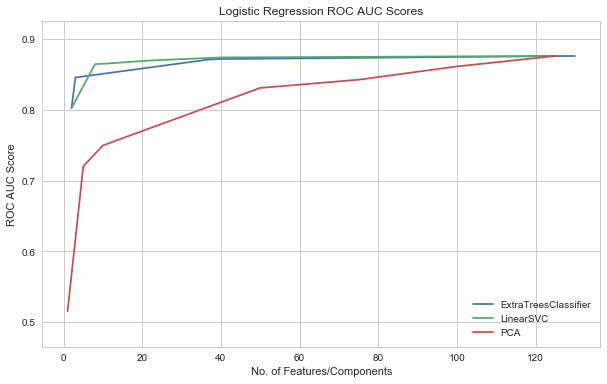

In [293]:
# convert our results into a dataframe
plt_results = pd.DataFrame(results_fs, columns=column_names)
fig,ax = plt.subplots(figsize=(10,6))

# loop through each classifier
for fs, data in plt_results.sort_values('features_selected').groupby('feat_selector'):

    # create the data
    x_data = data.features_selected
    y_data = data.roc_auc
    
    plt.plot(x_data, y_data, label=fs)

# limit the y axis
ax = plt.gca()
ax.set_ylim([min(plt_results.roc_auc)-0.05 , max(plt_results.roc_auc)+0.05])

# set titles
plt.title('Logistic Regression ROC AUC Scores')
plt.ylabel('ROC AUC Score')
plt.xlabel('No. of Features/Components')
plt.legend()

plt.show()

In [296]:
# View the detailed results
plt_results

,feat_selector,threshold,accuracy,rmse,roc_auc,features_selected
0,LinearSVC,1e-05,0.905429,0.307524,0.875977,125
1,LinearSVC,0.0001,0.905429,0.307524,0.875978,124
2,LinearSVC,0.01,0.905429,0.307524,0.873947,40
3,LinearSVC,0.02,0.905355,0.307644,0.869664,22
4,LinearSVC,0.03,0.905043,0.308150,0.865309,11
5,LinearSVC,0.04,0.905160,0.307962,0.864526,8
6,LinearSVC,mean,0.906015,0.306570,0.802449,2
7,ExtraTreesClassifier,1e-05,0.905434,0.307516,0.875986,130
8,ExtraTreesClassifier,0.0001,0.905434,0.307516,0.875984,127
9,ExtraTreesClassifier,0.01,0.905334,0.307679,0.871052,37


It appears that LinearSVC has performed the best.  We can acheive a roc auc score of ~87% using only 40 features (a thrid of the total number of features).  The ExtraTreesClassifer can achieve a similar score, however there appears to be a sharp drop off between threshold levels which could create a less robust model.

Although PCA doesn't select features (rather it selects components), we find that PCA would require over 120 components in order to match a score of 87%.  We are not reducing the complexity of our model in this case, and therefore we will not use PCA in this analysis. 

We will select LinearSVC as our feature selection technique, using a threshold of 0.01.

## Logistic Regression - Feature Selection - Hyperparameter Tuning
We know that LinearSVC feature selection performs best.  We can now fine tune our Logistic Regression classifier to see if we can acheive an even better score while using fewer features.  We were able to acheive an ROC AUC score of 87% and a cross validation score of 90% using no feature selection or hyperparameter tuning.  Let's see if we can get near this score.

In [298]:
# we will do hyperparameter tuning on our logisitic regression
param_grid = [{'clf__C':[0.001, 0.01, 1, 10, 100, 500, 1000]}]

# create pipeline
pipe_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold=0.01)),
    ('clf', LogisticRegression())
])

# create our grid search
grid_search = GridSearchCV(pipe_fs, param_grid, n_jobs=-1, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=False)

# perform the fit
grid_search.fit(X_train, y_train)

# print out our best params
grid_search.best_params_

{'clf__C': 1000}

With our parameters tuned, we bring it all together and perform one last test:

In [299]:
# create pipeline
pipe_lr_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold=0.01)),
    ('clf', LogisticRegression(C=1000))
])

# fit the data
pipe_lr_fs.fit(X_train, y_train)

# predict X
y_pred_lr_fs = pipe_lr_fs.predict(X_train)
y_pred_test_lr_fs = pipe_lr_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_lr_fs = pipe_lr_fs.predict_proba(X_train)[:,1]
y_score_test_lr_fs = pipe_lr_fs.predict_proba(X_test)[:,1]

# find the scores
r2_score = pipe_lr_fs.score(X_train, y_train)
mse = mean_squared_error(y_train, y_pred_lr_fs)
roc_auc = roc_auc_score(y_train, y_score_lr_fs)

r2_score_test = pipe_lr.score(X_test, y_test)
mse_test = mean_squared_error(y_test,y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_score_test)

# print scores
print('Training Scores')
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing Scores')
print('R2: {}'.format(r2_score_test))
print('RSE: {}'.format(np.sqrt(mse_test)))
print('ROC AUC: {}'.format(roc_auc_test))



Training Scores
R2: 0.9147032571208256
RSE: 0.2920560611923238
ROC AUC: 0.9060403784462219

Testing Scores
R2: 0.9021453243337453
RSE: 0.30781355398394106
ROC AUC: 0.8737729370665167


In [300]:
# let's find the cross validation score
scores = cross_val_score(pipe_lr_fs, X, y, cv=5)
scores

array([ 0.95656652,  0.94294033,  0.91644055,  0.88496732,  0.85323827])

In [301]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.07558)


Using cross validation, we see that we have achieved a similar cross validation score.

Out of curiosity - what are the top 5 rated features?

In [303]:
from operator import itemgetter

sorted(list(zip(list(X.columns), list(pipe_lr_fs.named_steps['feature_selection'].estimator_.coef_[0]))), key=itemgetter(1), reverse=True)[:5]

[('recoveries', 13.557974955043633),
 ('collection_recovery_fee', 0.61039988547649449),
 ('installment', 0.079098494968777328),
 ('term', 0.072414814794623972),
 ('issue_d_year', 0.059802608989202165)]

Through hyperparamter tuning and feature selection, we can find a model that has a cross validation score near 91% and a ROC AUC score of 91 on our training dataset. 

The most important features appear to be recoveries, collection_recovery_fee, installment and term.  

This is a great improvement from where we began using a model that only predicticed around 55%.  Can we improve on this score using a different model?

## Random Forest Classifier
We've performed feature selection & hyperparamter tuning on our logistic regression classifier to achieve a roc auc score of 91%.  Is it possible to improve this score by using a different classifier?  

Let's have a look at the Random Forest Classifier to see.  We will first look at using only feature selection to find out how well we score.

In [313]:
from sklearn.tree import DecisionTreeClassifier

pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold=0.01)),
    ('rfc', RandomForestClassifier(random_state=42))
])

# fit the classifier
pipe_rf_fs.fit(X_train, y_train)

# predict 
y_pred_rf_fs = pipe_rf_fs.predict(X_train)
y_pred_rf_fs_test = pipe_rf_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_rf_fs = pipe_rf_fs.predict_proba(X_train)[:,1]
y_score_rf_fs_test = pipe_rf_fs.predict_proba(X_test)[:,1]

# find the scores
r2_score = pipe_rf_fs.score(X_train, y_train)
mse = mean_squared_error(y_train,y_pred_rf_fs)
roc_auc = roc_auc_score(y_train, y_score_rf_fs)

# find the scores
r2_score_test = pipe_rf_fs.score(X_test, y_test)
mse_test = mean_squared_error(y_test,y_pred_rf_fs_test)
roc_auc_test = roc_auc_score(y_test, y_score_rf_fs_test)

# print scores
print('Training')
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing')
print('R2: {}'.format(r2_score_test))
print('RSE: {}'.format(np.sqrt(mse_test)))
print('ROC AUC: {}'.format(roc_auc_test))

Training
R2: 0.9885073862225955
RSE: 0.10720360897565226
ROC AUC: 0.9999110399761032

Testing
R2: 0.9223943974395539
RSE: 0.2785778213721368
ROC AUC: 0.891335824593911


In [314]:
print(classification_report(y_test, y_pred_rf_fs_test, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.92      0.99      0.95     50955
          1       0.97      0.62      0.75     12159

avg / total       0.93      0.92      0.92     63114



In [315]:
# let's find the cross validation score
scores = cross_val_score(pipe_rf_fs, X, y, cv=5)
scores

array([ 0.99027549,  0.95674477,  0.36856073,  0.7483066 ,  0.86399287])

In [316]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.44957)


The random forest classifier performs well, but it appears to have a wide variance when scoring.  The cross validation score is only 79%, having a terrible prediction on the 3rd pass. 

We do have a good ROC AUC score on our testing data, so let's try tuning the parameters to find out if we can achieve a more consistent score.

## Random Forest Classifier - Feature Selection & Hyperparameter Tuning
In order to tune our parameters, we will first look at each parameter individually, identifying a smaller range for each parameter which will then be used to tuning the final classifier. 

In [317]:
def plot_results(clf, param_name, param_values, plot_index):
    """
    Description
    -----------
        Allows us to test a parameter range and plot the results
        
    Parameters
    -----------
    clf: The classifier to be used for tuning
    
    param_name: name of the parameter to be tuned
    
    param_values: an array of values to be tested for the given parameter
    
    plot_index: identifies the index of the given subplot.  For this given setup, we 
        assume that we are using a 3 cols x 2 row setup

    
    """

    # create the grid search
    grid_search = GridSearchCV(clf, 
                               param_grid = {param_name:param_values},
                               return_train_score=True)
    
    # fit the estimator
    grid_search.fit(X_train, y_train)
    
    # create a dictionary to store the scores
    scores_dic = {}
    
    # loop through the parameter values tested
    for i, param_dic in enumerate(grid_search.cv_results_['params']):
        
        # Store the parameter tested with the related mean training score
        scores_dic[param_dic[param_name]] = grid_search.cv_results_['mean_train_score'][i]
    
    # create a dataframe from the parameter scores
    scores_df = pd.DataFrame.from_dict(scores_dic, orient='index')
    scores_df.reset_index(inplace=True)
    scores_df.columns = ['param', 'score']
    
    # plot the result
    plt.subplot(3, 2, plot_index)
    
    # if we are plotting max_features, we need to adjust the x values, as they are not
    # numeric.  Otherwise, we can just use the parameter values
    if param_name == 'max_features':
        plt.plot(np.arange(len(scores_df)), scores_df.score)
        plt.xticks(np.arange(len(scores_df)), scores_df.param.values)
    else:
        plt.plot(scores_df.param, scores_df.score)

    # add a title
    plt.title(param_name)


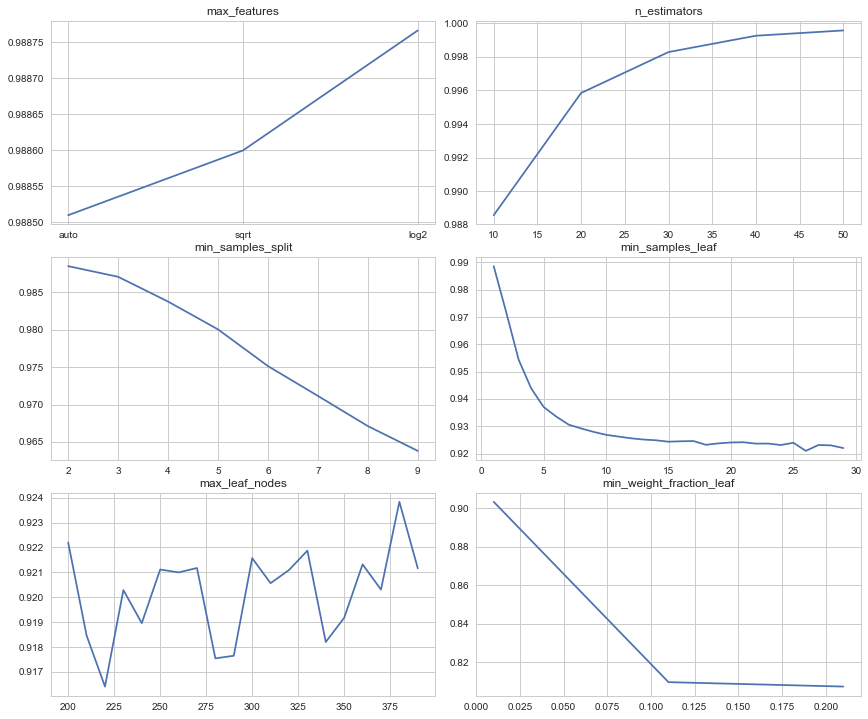

In [318]:
# Create the param_grid for testing
param_grid = {'max_features':['auto', 'sqrt', 'log2'],
              'n_estimators':[10, 20, 30, 40, 50],
              'min_samples_split': np.arange(2,10,1),
              'min_samples_leaf': np.arange(1,30,1),
              'max_leaf_nodes': np.arange(200,400,10),
              'min_weight_fraction_leaf': np.arange(0.01,0.3, 0.1)
             }

# create figure area
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.tight_layout()

# loop through each parameter & value range, plotting the accuracy results
for i, (k, v) in enumerate(param_grid.items()):

    # call to display graph
    plot_results(RandomForestClassifier(n_jobs=-1), k, v, i+1)

plt.show()

From the above plots, we now have a general idea of how well each parameter performs given a wide range of values.  

We can use this plot to narrow the range for each paramter and perform a final test using RandomizedSearchCV. 

In [330]:
# create the parameter grid
param_grid = {'rfc__n_estimators':[10, 20, 30, 40, 50],
              'rfc__min_samples_split': np.arange(2,5,1),
              'rfc__min_samples_leaf': np.arange(1,5,1),
              'rfc__max_leaf_nodes': np.arange(375,400,5),
              'rfc__min_weight_fraction_leaf': np.arange(0.01,0.1, 0.01)
             }

pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold=0.01)),
    ('rfc', RandomForestClassifier(max_features='log2', random_state=42))
])

random_search = RandomizedSearchCV(pipe_rf_fs, param_grid, scoring=['accuracy', 'roc_auc'],
                                  refit='roc_auc')

# fit the classifier
random_search.fit(X_train, y_train)

# find best params
random_search.best_params_

{'rfc__max_leaf_nodes': 385,
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 4,
 'rfc__min_weight_fraction_leaf': 0.01,
 'rfc__n_estimators': 50}

The RandomizedSearchCV has provided us with the most optimal parameters.  We can use these in a classifer below to produce our final output.

In [331]:
# define our final pipeline
pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False), threshold=0.01)),
    ('rfc', RandomForestClassifier(random_state=42, max_leaf_nodes=385,
                                  min_samples_leaf=2, min_samples_split=4,
                                  min_weight_fraction_leaf=0.01, n_estimators=50))
])

# fit the classifier
pipe_rf_fs.fit(X_train, y_train)

# predict 
y_pred_rf_fs = pipe_rf_fs.predict(X_train)
y_pred_rf_fs_test = pipe_rf_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_rf_fs = pipe_rf_fs.predict_proba(X_train)[:,1]
y_score_rf_fs_test = pipe_rf_fs.predict_proba(X_test)[:,1]

# find the scores
r2_score = pipe_rf_fs.score(X_train, y_train)
mse = mean_squared_error(y_train,y_pred_rf_fs)
roc_auc = roc_auc_score(y_train, y_score_rf_fs)

# find the scores
r2_score_test = pipe_rf_fs.score(X_test, y_test)
mse_test = mean_squared_error(y_test,y_pred_rf_fs_test)
roc_auc_test = roc_auc_score(y_test, y_score_rf_fs_test)

# print scores
print('Training')
print('R2: {}'.format(r2_score))
print('RSE: {}'.format(np.sqrt(mse)))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing')
print('R2: {}'.format(r2_score_test))
print('RSE: {}'.format(np.sqrt(mse_test)))
print('ROC AUC: {}'.format(roc_auc_test))

Training
R2: 0.9237716476795589
RSE: 0.27609482487080617
ROC AUC: 0.9214908538510296

Testing
R2: 0.923661945051811
RSE: 0.27629342183300165
ROC AUC: 0.9176376686011063


In [332]:
# let's find the cross validation score
scores = cross_val_score(pipe_rf_fs, X, y, cv=5)
scores

array([ 0.96205264,  0.95547721,  0.91632172,  0.88546247,  0.86965736])

In [333]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.07345)


Using feature selection and hyperparameter tuning, we were able to improve our roc auc score to ~92%.  Our cross validation score has also become more stable, producing a 92% cv score. 

Using this final classifier, we can compare the ROC curves of 4 different classifiers we expored in this notebook

1. Logistic Regression using only engineered features
2. Logistic Regression using all features
3. Logistic Regression using select features
4. Random Forest using select features

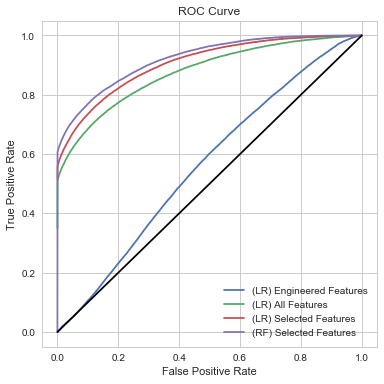

In [340]:
# create plot
plt.figure(figsize=(6,6))

# find roc curve for logisitic regression - Engineered Features
fpr_lr_fe, tpr_lr_fe, thresholds = roc_curve(y_train_bal, y_score_fe)

# find roc curve for logisitic regression - All Features
fpr_lr_af, tpr_lr_af, thresholds = roc_curve(y_train, y_score_lr_af)

# find roc curve for logisitic regression - Selected Features
fpr_lr_fs, tpr_lr_fs, thresholds = roc_curve(y_train, y_score_lr_fs)

# find roc curve for Random Forest - Selected Features
fpr_rf_fs, tpr_rf_fs, thresholds = roc_curve(y_train, y_score_rf_fs)

# plot ROC curve & 50% line
plt.plot(fpr_lr_fe, tpr_lr_fe, label='(LR) Engineered Features')
plt.plot(fpr_lr_af, tpr_lr_af, label='(LR) All Features')
plt.plot(fpr_lr_fs, tpr_lr_fs, label='(LR) Selected Features')
plt.plot(fpr_rf_fs, tpr_rf_fs, label='(RF) Selected Features')
plt.plot([0,1], [0,1], color='black')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

## Conclusion

We've taken steps throughout this notebook to improve performance of our model to predict Lending Club defaults.

We've seen how using too few features can causes poor performance in a model.  We've also seen how model tuning can be used to reduce complexity and improve model performance.

Our Logistic Regression classifier has gone through interations to improve the roc auc score from 55% to 87%.  

Ultimately, our Random Forest classifier has out performed our Logistic Regression model to produce a 91% roc auc score (as seen in the ROC Curve plot above).  A Logistic Regression searches for a single linear decision boudnary in our feature space, whereas the Random Forest produces non-linear decision boundaries.  The Random Forest has proven to be better suited for this particular case.  